In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure
import skimage

from pathlib import Path
import os, sys

from dask import bag, diagnostics


sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)

<module 'leukopy_lib' from '/home/marie-anne/code/Leukopy/notebooks/leukopy_lib.py'>

## Import normal peripheral blood cell dataset merged



In [2]:
#get path to data/main_dir
path_name = '../../data/main_dataset_2/'
path = Path(path_name)

In [3]:
df = pd.DataFrame()
df['img_path'] = [str(image_path) for ext in ['jpg', 'tiff', 'png'] 
                  for image_path in path.glob(f'**/*.{ext}')]

df['label'] = [image_path.parts[-2] for ext in ['jpg', 'tiff', 'png'] 
               for image_path in path.glob(f'**/*.{ext}')]

df['label_2'] = [image_path.stem.split('_')[0] 
                 for ext in ['jpg', 'tiff', 'png'] for image_path in path.glob(f'**/*.{ext}')]
df.head()

,img_path,label,label_2
0,../../data/main_dataset_2/SNE/SNE_263049.jpg,SNE,SNE
1,../../data/main_dataset_2/SNE/SNE_829664.jpg,SNE,SNE
2,../../data/main_dataset_2/SNE/SNE_987578.jpg,SNE,SNE
3,../../data/main_dataset_2/SNE/SNE_66862.jpg,SNE,SNE
4,../../data/main_dataset_2/SNE/SNE_935764.jpg,SNE,SNE


In [8]:
barca = ['MO', 'ERB', 'PLATELET', 'BA', 'BNE', 'SNE', 'LY', 'EO', 'MMY', 'PMY', 'MY']
munich = ['MON', 'EBO', 'BAS', 'NGB', 'NGS', 'LYT', 'EOS', 'MMZ', 'PMO', 'MYB']

df.loc[df.label_2.isin(barca),'origin']='barcelone'
df.loc[df.label_2.isin(munich),'origin']='munich'
df.origin.fillna('raabin', inplace=True)
df

,img_path,label,label_2,origin
0,../../data/main_dataset_2/SNE/SNE_263049.jpg,SNE,SNE,barcelone
1,../../data/main_dataset_2/SNE/SNE_829664.jpg,SNE,SNE,barcelone
2,../../data/main_dataset_2/SNE/SNE_987578.jpg,SNE,SNE,barcelone
3,../../data/main_dataset_2/SNE/SNE_66862.jpg,SNE,SNE,barcelone
4,../../data/main_dataset_2/SNE/SNE_935764.jpg,SNE,SNE,barcelone
...,...,...,...,...
37684,../../data/main_dataset_2/ERB/EBO_0042.tiff,ERB,EBO,munich
37685,../../data/main_dataset_2/ERB/EBO_0044.tiff,ERB,EBO,munich
37686,../../data/main_dataset_2/ERB/EBO_0074.tiff,ERB,EBO,munich
37687,../../data/main_dataset_2/ERB/EBO_0003.tiff,ERB,EBO,munich


In [23]:
df.iloc[:, 1:].nunique()

label       11
label_2    229
origin       3
dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

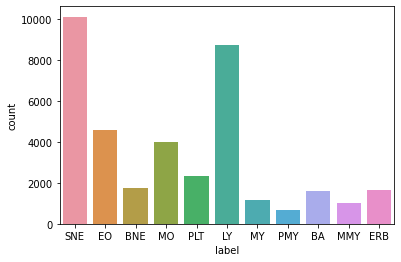

In [24]:
sns.countplot(x=df.label)

### Import images with dask

### Add height, width, brightness, luminance to df

In [25]:
df.img_path.to_list()[-1]

'../../data/main_dataset_2/ERB/EBO_0078.tiff'

In [26]:
tst = io.imread(df.img_path.to_list()[-1])
tst.shape[0] 

400

In [27]:
def add_columns(filename):
    
    im = io.imread(filename)
    temp = pd.DataFrame(index=[0])

    temp['height'] = im.shape[0] 
    temp['width'] = im.shape[1]
    temp['mean_brightness'] = np.mean(im)    
    
    im_gray = color.rgb2grey(im)
    temp['mean_luminance'] = np.mean(im_gray)
    
    return temp

In [28]:
addcol_bag = bag.from_sequence(df.img_path.to_list()).map(add_columns)
with diagnostics.ProgressBar():
    res = addcol_bag.compute()

[########################################] | 100% Completed |  1min  5.5s


In [29]:
df.shape

(37689, 4)

In [30]:
len(res)

37689

In [31]:
res_df = pd.concat(res).reset_index(drop=True)
df_temp = df.join(res_df)
df_temp

,img_path,label,label_2,origin,height,width,mean_brightness,mean_luminance
0,../../data/main_dataset_2/SNE/SNE_263049.jpg,SNE,SNE,barcelone,363,360,200.803423,0.783345
1,../../data/main_dataset_2/SNE/SNE_829664.jpg,SNE,SNE,barcelone,363,360,197.570620,0.766877
2,../../data/main_dataset_2/SNE/SNE_987578.jpg,SNE,SNE,barcelone,363,360,197.110430,0.765792
3,../../data/main_dataset_2/SNE/SNE_66862.jpg,SNE,SNE,barcelone,363,360,200.949015,0.783442
4,../../data/main_dataset_2/SNE/SNE_935764.jpg,SNE,SNE,barcelone,363,360,188.113246,0.724006
...,...,...,...,...,...,...,...,...
37684,../../data/main_dataset_2/ERB/EBO_0042.tiff,ERB,EBO,munich,400,400,227.576473,0.836840
37685,../../data/main_dataset_2/ERB/EBO_0044.tiff,ERB,EBO,munich,400,400,221.986736,0.796505
37686,../../data/main_dataset_2/ERB/EBO_0074.tiff,ERB,EBO,munich,400,400,223.501759,0.806716
37687,../../data/main_dataset_2/ERB/EBO_0003.tiff,ERB,EBO,munich,400,400,221.993016,0.805431


In [32]:
df_temp.to_csv('../../data/PBC_dataset_normal_df_merged.csv', index=False)

In [33]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37689 entries, 0 to 37688
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   img_path         37689 non-null  object 
 1   label            37689 non-null  object 
 2   label_2          37689 non-null  object 
 3   origin           37689 non-null  object 
 4   height           37689 non-null  int64  
 5   width            37689 non-null  int64  
 6   mean_brightness  37689 non-null  float64
 7   mean_luminance   37689 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 2.3+ MB


In [34]:
df_temp.to_pickle('../../data/PBC_dataset_normal_df_merged.pkl')